# Exploration of Asheville temperature data
## Tools


In [1]:
# For loading data from NOAA
from urllib.request import urlretrieve
from os import mkdir, remove
from os.path import isfile
from time import sleep
from datetime import datetime

# For data manipulation and visualization
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from datetime import timedelta

# Curve fitting
from scipy.optimize import curve_fit, OptimizeWarning
from warnings import filterwarnings
filterwarnings('ignore', category = OptimizeWarning)

# Various mathematical tools
import numpy as np

## Data loading
WARNING: The first time this is run, at least 18 files will be pulled from NOAA's FTP, totaling over 30MB. In subsequent runs, only the most recent year will be updated.

In [2]:
# We will keep track of the first year of data, and the current year.
minyear = None
curryear = datetime.now().year

# Make a `data` directory if it doesn't already exist
try: mkdir('data')
except FileExistsError: pass

path = 'ftp://ftp.ncdc.noaa.gov/pub/data/uscrn/products/hourly02/YEAR/'
name = 'CRNH0203-YEAR-NC_Asheville_13_S.txt'

# Delete the current year's data so it can be refreshed
try: 
    remove('data/' + name.replace('YEAR', str(curryear)))
    sleep(5)
except: 
    pass

# Get all years' data as necessary
# Set `minyear` to be the first year that exists, or the first year loaded
for year in range(2000, curryear+1):
    if isfile('data/' + name.replace('YEAR', str(year))):
        if minyear is None: 
            minyear = year
        continue
    try:
        urlretrieve(
            (path + name).replace('YEAR', str(year)), 
            'data/' + name.replace('YEAR', str(year))
        )
        if minyear is None: 
            minyear = year
    except: 
        pass

In [3]:
# Get the column headers, which are kept in a 
# separate file on the NOAA FTP site
if not isfile('data/HEADERS.txt'):
    urlretrieve(
        'ftp://ftp.ncdc.noaa.gov/pub/data/uscrn/products/hourly02/HEADERS.txt', 
        'data/HEADERS.txt'
    )
    
header = pd.read_csv('data/HEADERS.txt', delim_whitespace = True)
cols = header.iloc[0].values
units = header.iloc[1].values

# Load all available data (150K+ rows)
df = pd.read_csv(
    'data/CRNH0203-%d-NC_Asheville_13_S.txt' % minyear, 
    delim_whitespace = True,
    names = cols
)

for year in range(minyear, curryear+1):
    df = df.append(
        pd.read_csv(
            'data/CRNH0203-%d-NC_Asheville_13_S.txt' % year, 
            delim_whitespace = True,
            names = cols
        )
    )

## Data cleaning

In [4]:
# Standardize NOAA's date & time formats
df['date'] = [
    datetime(d//10000, (d % 10000)//100, d % 100, t//100) 
    for d,t in zip(df.LST_DATE, df.LST_TIME)
]
df = df.sort_values('date')

# Convert Celsuis air temperature to Fahrenheit because Merica
df['Fahrenheit'] = df.T_HR_AVG * 9/5 + 32

# Remove missing measurements at start of data set
# (usually flagged as large negatives)
keepers = (df.Fahrenheit > -100) & (df.Fahrenheit < 150)
df = df.iloc[min(i for i,k in enumerate(keepers) if k):]

# Remove missing measurements from middle of data set 
keepers = (df.Fahrenheit > -100) & (df.Fahrenheit < 150)
print('Keeping %.2f%% of all data starting at ' % 
      (100 * keepers.mean()), end = '')
print('{:%Y-%m-%d %H:%M}'.format(df.date.min()))
print('(%d values missing out of %d total)' % 
      (sum(-keepers), len(keepers)))
df.loc[-keepers, 'Fahrenheit'] = None

Keeping 99.40% of all data starting at 2001-06-14 01:00
(896 values missing out of 148352 total)


In [5]:
# Are all dates accounted for?
print('Largest delay between data entries: %.0f hour(s)' 
    % (df.date.diff()[1:].max().seconds // 3600))

# What is the largest run of missing data?
gaps = pd.Series(
    i for i,k 
    in enumerate(keepers.astype(int).diff()[1:]) 
    if k != 0
).diff()[1::2]

print(
    'Longest consecutive sequence of missing temperatures: %.1f days'
     % (max(gaps) / 24)
)

Largest delay between data entries: 1 hour(s)
Longest consecutive sequence of missing temperatures: 4.3 days


In [6]:
# Store two versions of the data:
# With missing temperatures interpolated (for FFT later)
df_ = df[['date','Fahrenheit']].interpolate()
# With missing temperatures ignored (for classical fitting)
df = df[keepers]

## Data visualization and sine modeling

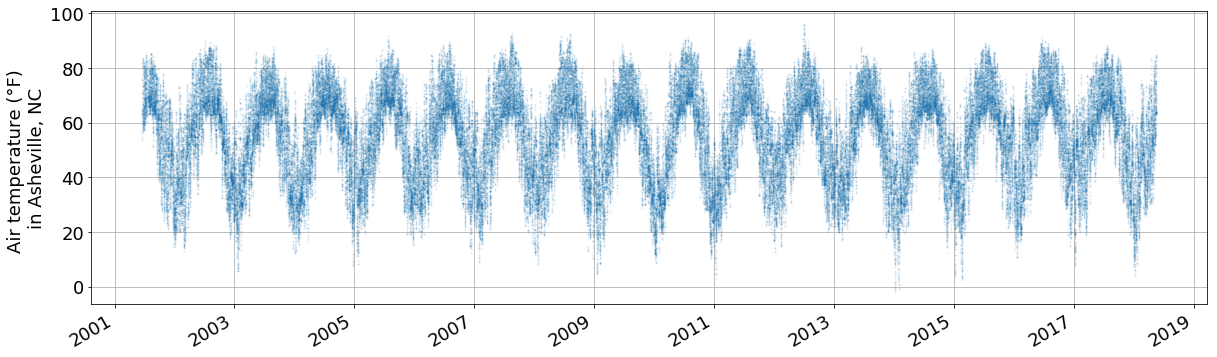

In [7]:
# A first look at the full temperature data
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = 20,6
plt.rcParams['font.size'] = 18
df.set_index('date').Fahrenheit.plot(
    marker = 'o', markersize = 1, lw = 0,
    alpha = .1, legend = False
)
plt.grid()
plt.xlabel('')
plt.ylabel('Air temperature (°F) \nin Asheville, NC')
plt.show()

In [8]:
# Create a sine function for fitting
mindate = df.date.apply(date2num).min()
def sine(x, a, b, c, d):    
    x_ = x - mindate 
    return a * np.sin(b * (x_ - c)) + d

In [9]:
# Fit the sine function
x = [date2num(t) for t in df.date]
p, _ = curve_fit(
    sine, x, df.Fahrenheit, 
    p0 = [20, 2*np.pi / 365, 0, 50]
)

In [10]:
T = (2*np.pi / p[1])
print('The best-fit sine function has a period of %.2f days.' % T)

The best-fit sine function has a period of 365.13 days.


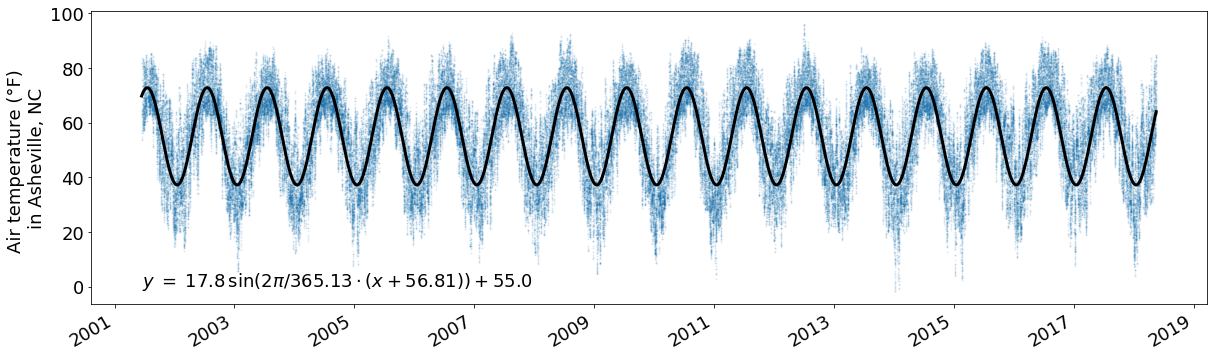

In [11]:
# Plot the model
dt = [num2date(t) for t in x]
plt.plot(
    dt, sine(x, *p), 
    lw = 3, c = 'black', zorder = 9001
)

# Plot the data again
df.set_index('date').Fahrenheit.plot(
    marker = 'o', markersize = 1, lw = 0,
    alpha = .1, legend = False    
)

# Display the sine formula
plt.text(
    dt[0], 0, 
    '$y \;=\; %.1f\,\sin(2\pi/%.2f\cdot(x %s %.2f)) + %.1f$' 
    % (p[0], T, '-' if p[2] > 0 else '+', abs(p[2]), p[3])
)

plt.xlabel('')
plt.ylabel('Air temperature (°F) \nin Asheville, NC')
plt.show()

## Residual analysis

In [12]:
# Calculate the residuals 
# (temperature variations not predicted by the sine function)
resid = df.set_index('date').Fahrenheit - sine(x, *p)
resid = resid.reset_index()

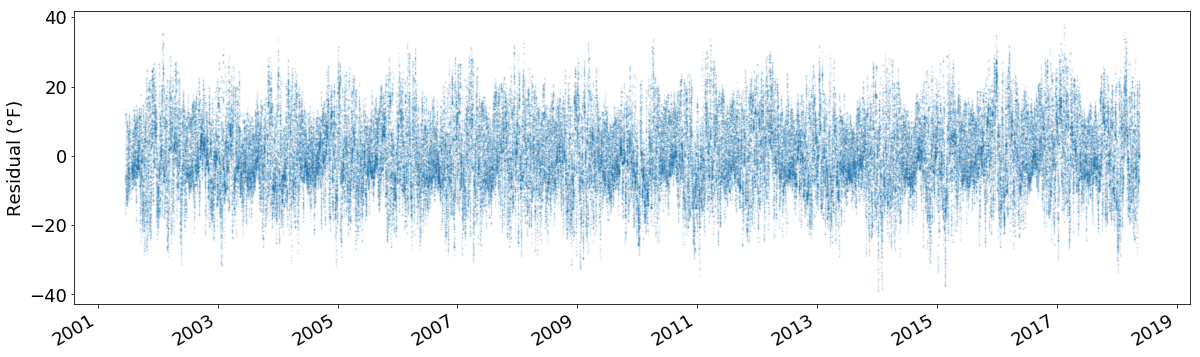

In [13]:
# Examine the residuals
resid.set_index('date').Fahrenheit.plot(
    marker = 'o', markersize = 1, lw = 0,
    alpha = .1, legend = False    
)
plt.xlabel('')
plt.ylabel('Residual (°F)')
plt.show()

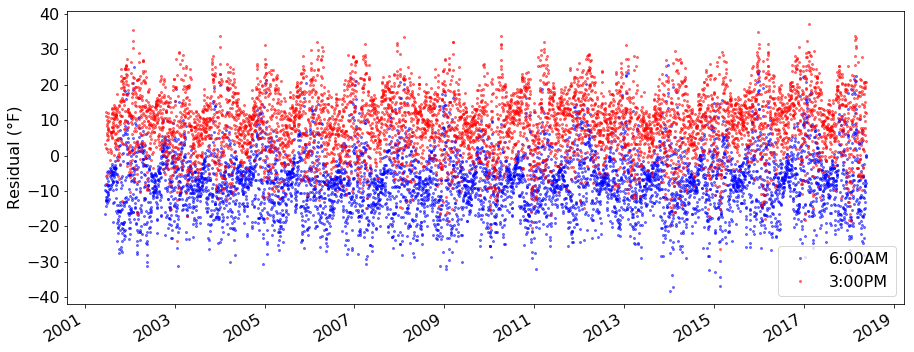

In [14]:
# Examine the residuals at the 
# coolest and warmest parts of the day
plt.rcParams['figure.figsize'] = 15,6
plt.rcParams['font.size'] = 16
ax = resid[resid.date.dt.hour == 6].set_index('date').plot(
    marker = 'o', markersize = 2, lw = 0, 
    alpha = .5, c = 'blue', legend = False
)
resid[resid.date.dt.hour == 15].set_index('date').plot(
    marker = 'o', markersize = 2, lw = 0, 
    alpha = .5, c = 'red', legend = False,
    ax = ax
)
plt.legend(['6:00AM', '3:00PM'])
plt.xlabel('')
plt.ylabel('Residual (°F)')
plt.show()

In [15]:
# New columns for convenience
resid['hour'] = resid.date.dt.hour
resid['day_of_year'] = resid.date.dt.dayofyear

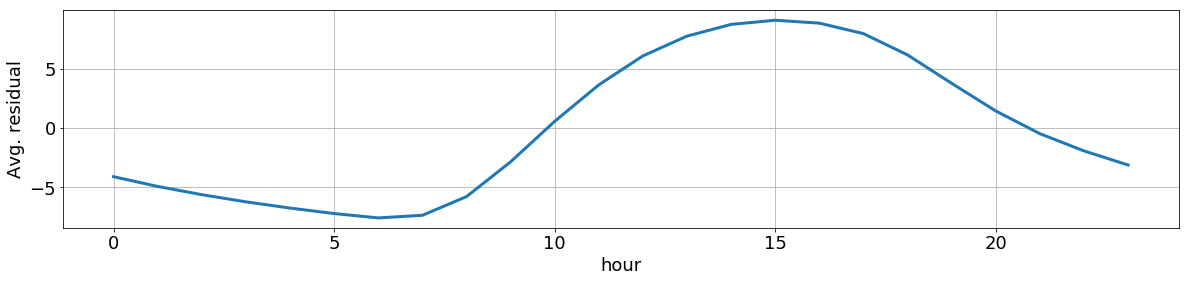

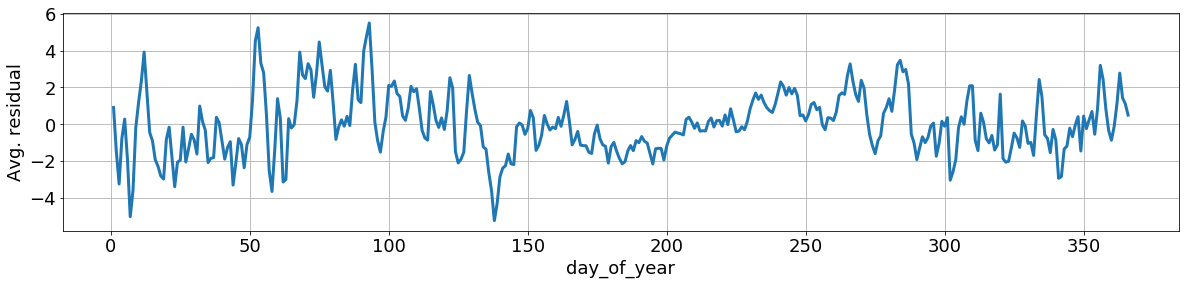

In [16]:
# Avergage residuals by time of day, and day of year
plt.rcParams['figure.figsize'] = 20,4
plt.rcParams['font.size'] = 18

resid.groupby('hour').Fahrenheit.mean().plot(lw = 3)
plt.ylabel('Avg. residual')
plt.grid()
plt.show()

resid.groupby('day_of_year').Fahrenheit.mean().plot(lw = 3)
plt.ylabel('Avg. residual')
plt.grid()
plt.show()

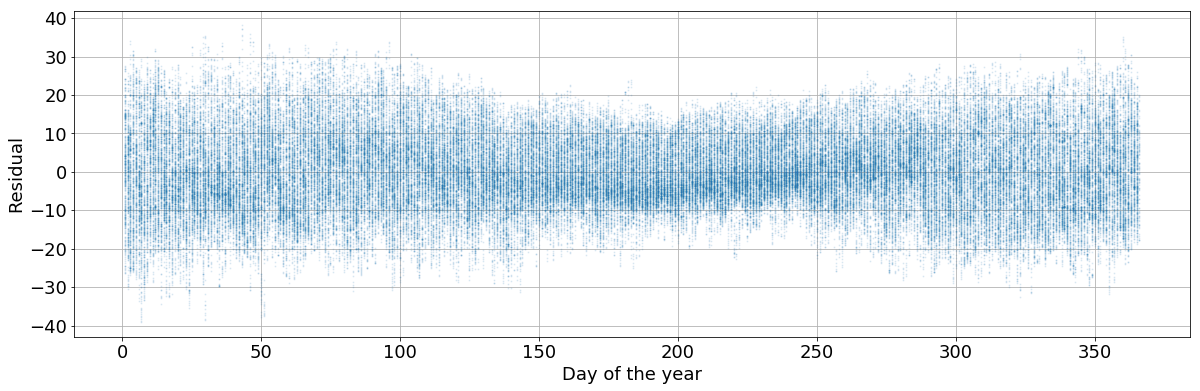

In [17]:
# What's going on with residuals by day of the year?
# Take a closer look
plt.rcParams['figure.figsize'] = 20,6
plt.rcParams['font.size'] = 18
resid.plot(
    'day_of_year', 'Fahrenheit',
    marker = 'o', markersize = 1, lw = 0,
    alpha = .1, legend = False, 
)
plt.xlabel('Day of the year')
plt.ylabel('Residual')
plt.grid()
plt.show()

In [18]:
# Something weird happening around days 150 to 250
# For convenience, make indexes for "summer" and "daytime"
summer = (resid.day_of_year >= 150) & (resid.day_of_year <= 250)
daytime = (resid.hour > 5) & (resid.hour < 23)

datestrings = resid[summer].date.astype(str).str[5:10]
print('"Summer" is between %s and %s.' % 
      (datestrings.min(), datestrings.max()))

"Summer" is between 05-29 and 09-07.


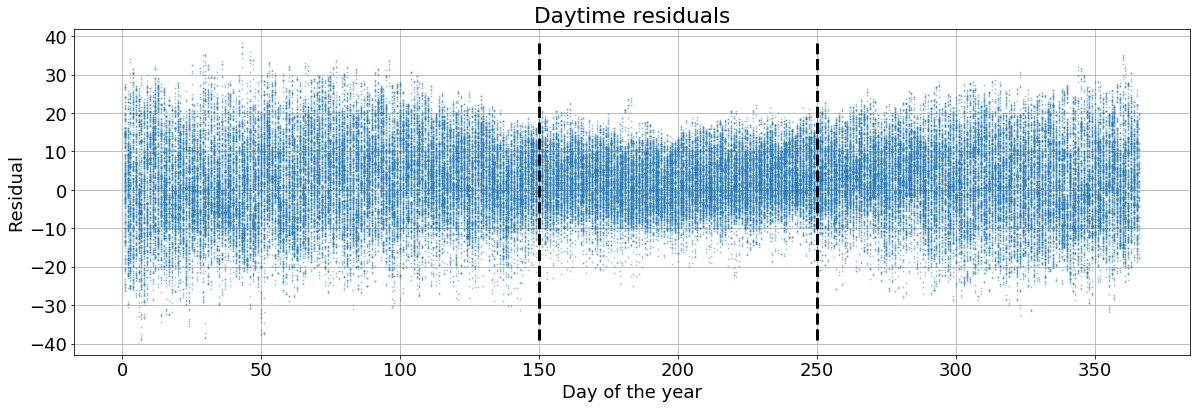

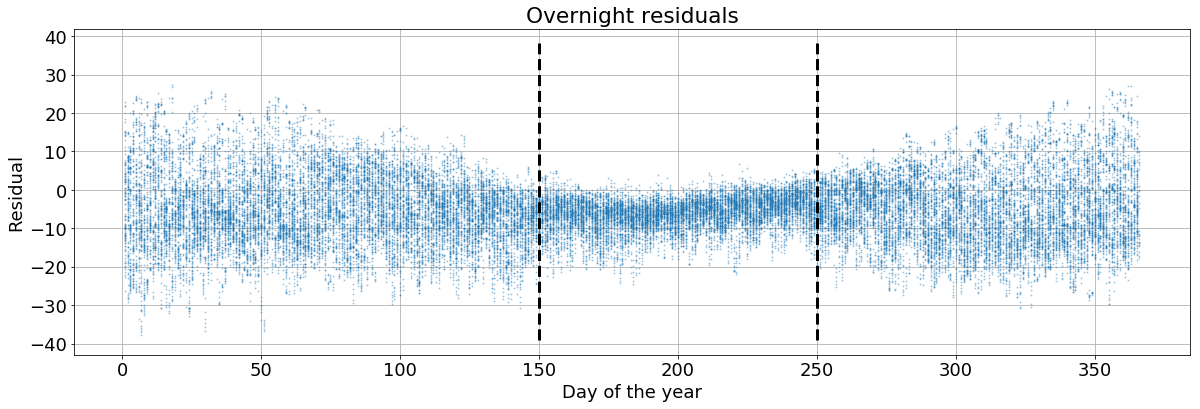

In [19]:
# Look at day-time and night-time residuals separately
resid[daytime].plot(
    'day_of_year', 'Fahrenheit',
    marker = 'o', markersize = 1, lw = 0, 
    alpha = .3, legend = False
)
plt.plot(
    [150]*2, resid.Fahrenheit.quantile([0,1]), 'k--', 
    [250]*2, resid.Fahrenheit.quantile([0,1]), 'k--', 
    lw=3
)
plt.xlabel('Day of the year')
plt.ylabel('Residual')
plt.title('Daytime residuals')
plt.grid()
plt.show()

resid[-daytime].plot(
    'day_of_year', 'Fahrenheit',
    marker = 'o', markersize = 1, lw = 0, 
    alpha = .3, legend = False
)
plt.plot(
    [150]*2, resid.Fahrenheit.quantile([0,1]), 'k--', 
    [250]*2, resid.Fahrenheit.quantile([0,1]), 'k--', 
    lw=3
)
plt.xlabel('Day of the year')
plt.ylabel('Residual')
plt.title('Overnight residuals')
plt.grid()
plt.show()

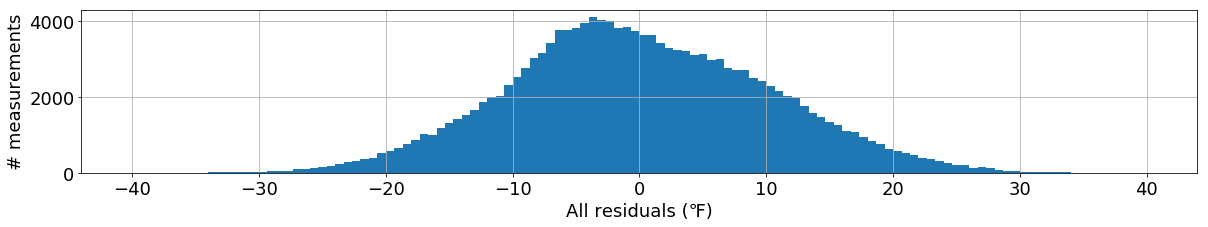

RMSE 10.146506525446023


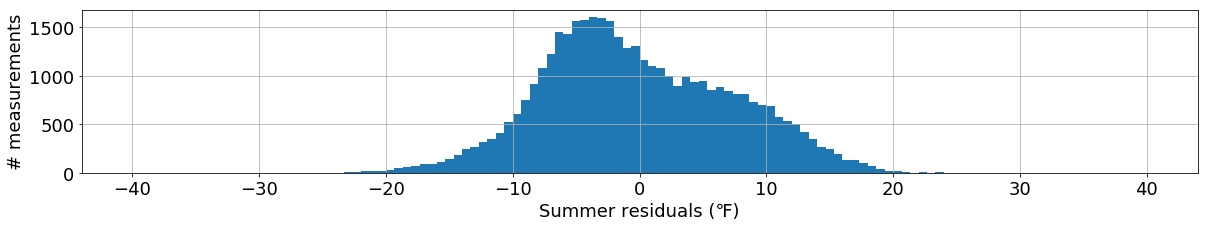

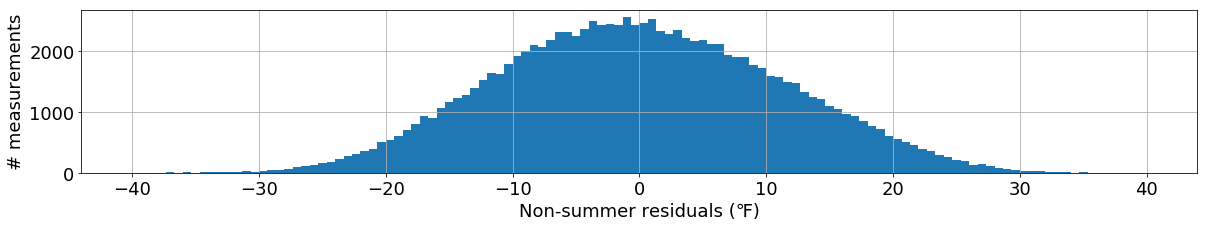

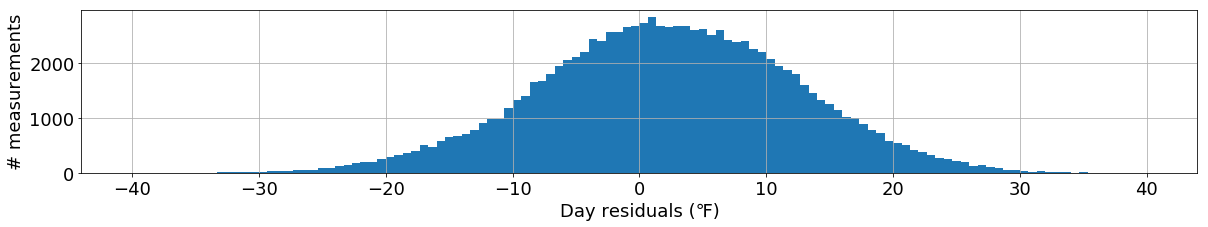

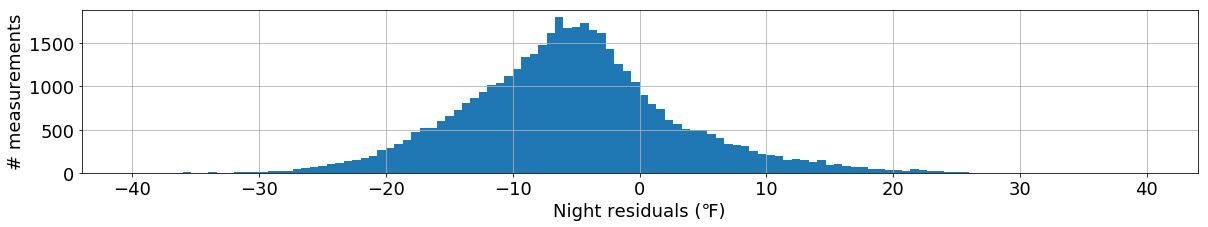

In [20]:
# Distributions of the residuals
plt.rcParams['figure.figsize'] = 20,3
plt.rcParams['font.size'] = 18

resid.Fahrenheit.hist(bins = np.linspace(-40,40,121))
plt.xlabel('All residuals (℉)')
plt.ylabel('# measurements')
plt.show()

print('RMSE', (np.mean(resid.Fahrenheit**2))**.5)

resid[summer].Fahrenheit.hist(bins = np.linspace(-40,40,121))
plt.xlabel('Summer residuals (℉)')
plt.ylabel('# measurements')
plt.show()

resid[-summer].Fahrenheit.hist(bins = np.linspace(-40,40,121))
plt.xlabel('Non-summer residuals (℉)')
plt.ylabel('# measurements')
plt.show()

resid[daytime].Fahrenheit.hist(bins = np.linspace(-40,40,121))
plt.xlabel('Day residuals (℉)')
plt.ylabel('# measurements')
plt.show()

resid[-daytime].Fahrenheit.hist(bins = np.linspace(-40,40,121))
plt.xlabel('Night residuals (℉)')
plt.ylabel('# measurements')
plt.show()

## Second level of sine modeling

In [21]:
# Create and fit another sine function
def sine_h(h, a, c, d):
    return a * np.sin(2*np.pi/24 * (h - c)) + d

p_h, _ = curve_fit(
    sine_h, resid.hour, resid.Fahrenheit, 
    p0 = [5, 0, 0]
)

In [22]:
# Does the amplitude of day-to-day oscillations 
# differ between summer and non-summer?
print('Summer amplitude:', end = ' ')
print(curve_fit(
    sine_h, 
    resid[summer].hour, resid[summer].Fahrenheit, 
    p0 = [5, 0, 0]
)[0][0])

print('Non-summer amplitude:', end = ' ')
print(curve_fit(
    sine_h, 
    resid[-summer].hour, resid[-summer].Fahrenheit, 
    p0 = [5, 0, 0]
)[0][0])

Summer amplitude: -8.24996671774482
Non-summer amplitude: -8.15521475733439


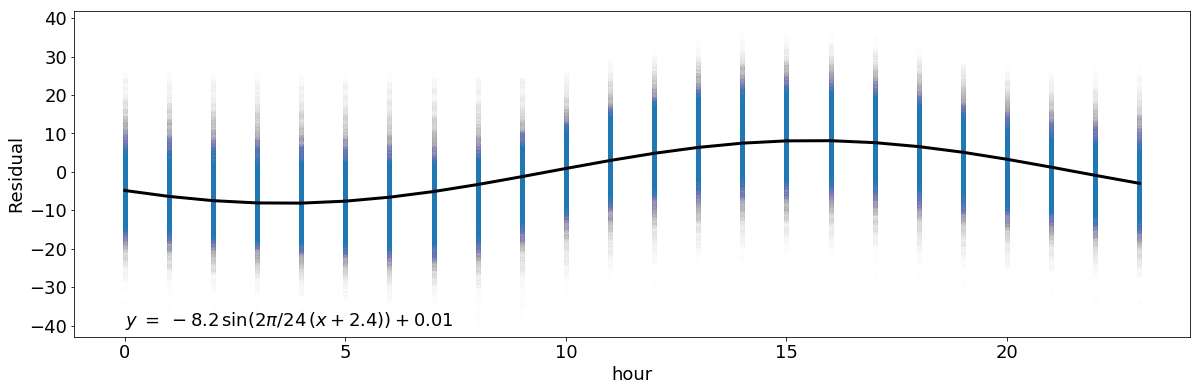

In [23]:
# Compare new sine function to residuals
plt.rcParams['figure.figsize'] = 20,6
plt.rcParams['font.size'] = 18
resid.set_index('hour').Fahrenheit.plot(
    marker = 'o', markersize = 5, lw = 0, 
    alpha = .005, legend = False
)
plt.plot(
    range(24), sine_h(range(24), *p_h),
    lw = 3, c = 'black', zorder = 9001
)
plt.text(
    0, -40, 
    '$y \;=\; %.1f\,\sin(2\pi/24\,(x %s %.1f)) + %.2f$' 
    % (p_h[0], '-' if p_h[1] > 0 else '+', abs(p_h[1]), p_h[2])
)
plt.ylabel('Residual')
plt.show()

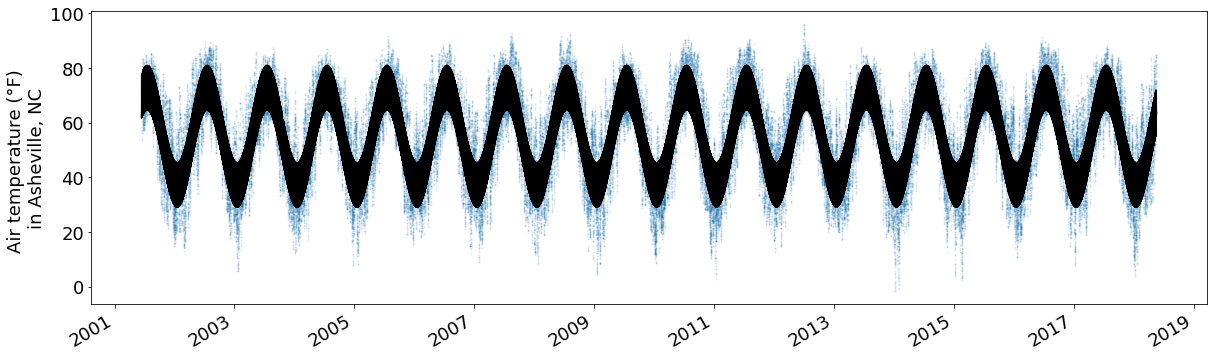

In [24]:
# Plot the two-level model
plt.plot(
    dt, sine(x, *p) + 
    sine_h(df.date.dt.hour, *p_h),
    c = 'black', zorder = 9001
)

# Plot the data again
df.set_index('date').Fahrenheit.plot(
    marker = 'o', markersize = 1, lw = 0,
    alpha = .1, legend = False
)

plt.xlabel('')
plt.ylabel('Air temperature (°F) \nin Asheville, NC')
plt.show()

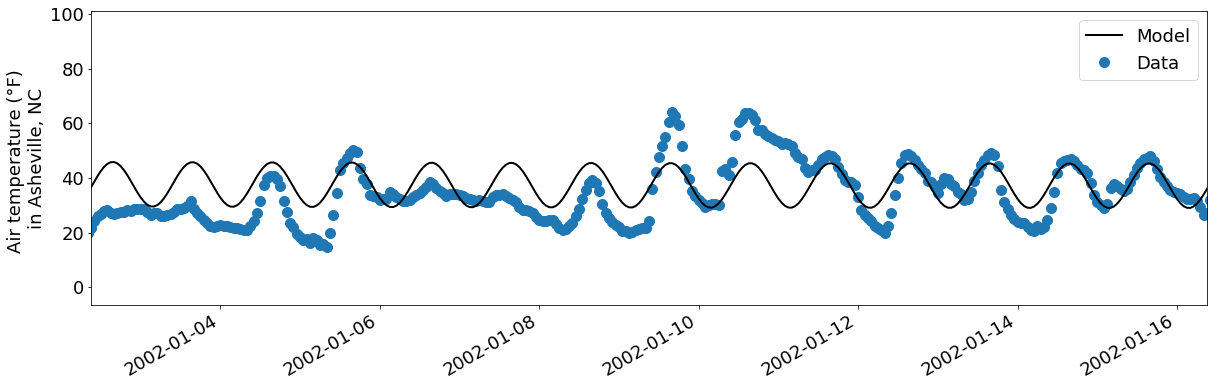

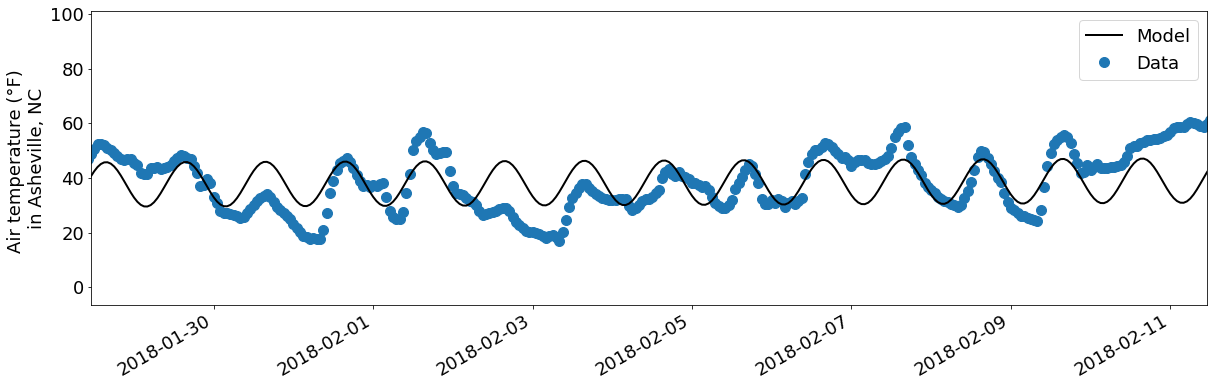

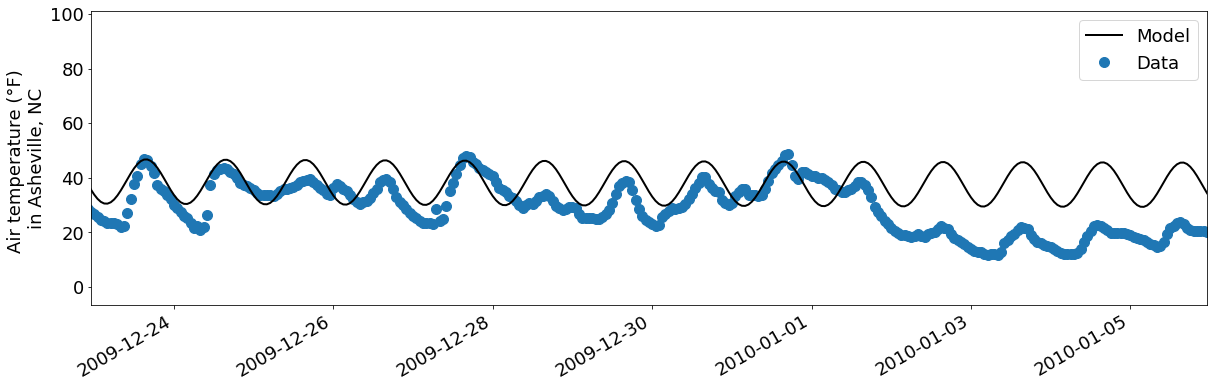

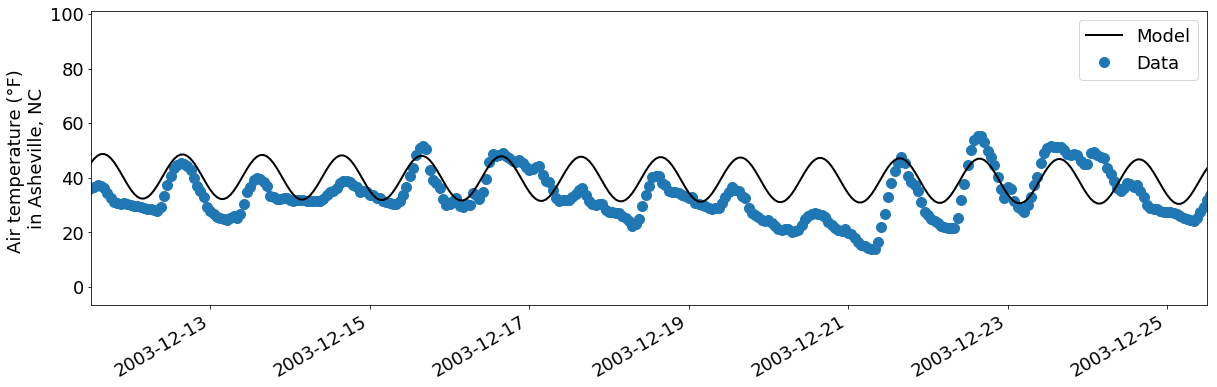

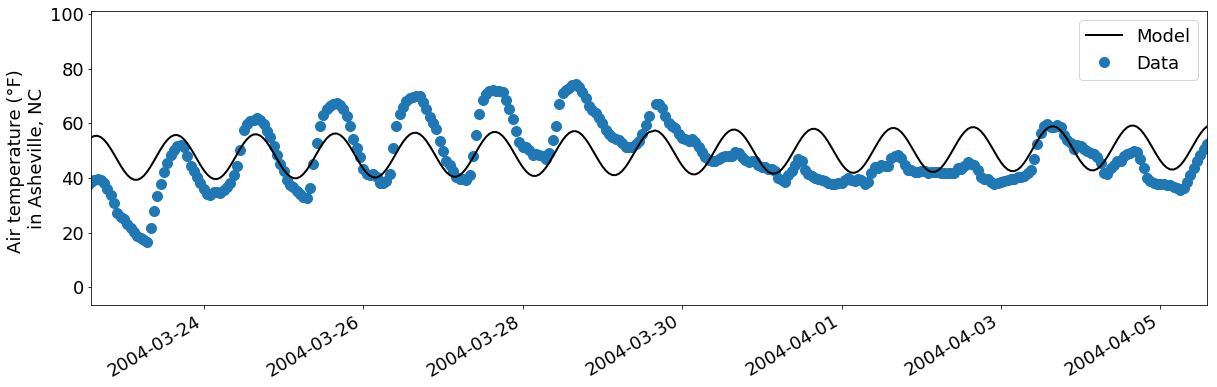

In [25]:
# Compare data and model on 5 randomly-selected short timescales
window = 14  # days to show at a time
for startdt in pd.to_datetime(df.date[:-window*24].sample(5).values):
    plt.plot(
        dt, sine(x, *p) + 
        sine_h(df.date.dt.hour, *p_h),
        lw = 2, c = 'black', zorder = 9001
    )
    df.set_index('date').Fahrenheit.plot(
        marker = 'o', alpha = 1, legend = False, 
        lw = 0, markersize = 10
    )
    plt.xlim([startdt, startdt + timedelta(days = window)])
    plt.xlabel('')
    plt.ylabel('Air temperature (°F) \nin Asheville, NC')
    plt.legend(['Model', 'Data'])
    plt.show()

In [26]:
# Calculate the residuals for the two-level model
resid =  df.set_index('date').Fahrenheit 
resid -= sine(x, *p) + sine_h(df.date.dt.hour.values, *p_h)
resid = resid.reset_index()

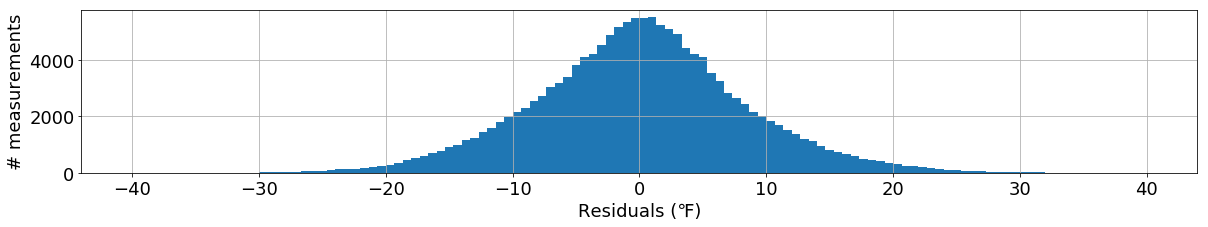

RMSE 8.342465211028678


In [27]:
# Distributions of the residuals
plt.rcParams['figure.figsize'] = 20,3
plt.rcParams['font.size'] = 18

resid.Fahrenheit.hist(bins = np.linspace(-40,40,121))
plt.xlabel('Residuals (℉)')
plt.ylabel('# measurements')
plt.show()

print('RMSE', (np.mean(resid.Fahrenheit**2))**.5)

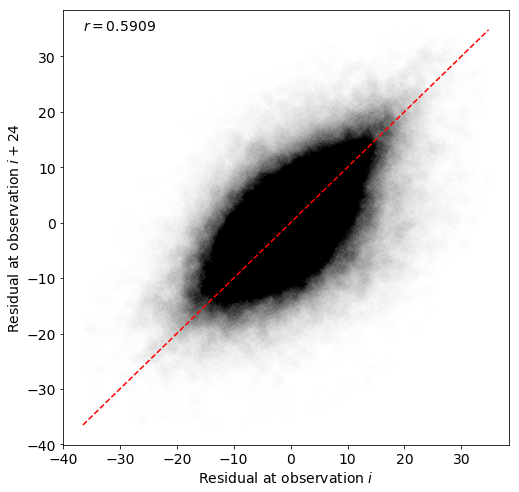

In [28]:
# Is there autocorrelation in the residuals?
# Plot residuals vs. one-day-lagged residuals
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['font.size'] = 14
plt.scatter(
    resid.Fahrenheit.values[:-24],
    resid.Fahrenheit.values[24:],
    s = 100, alpha = .005, c = 'black'
)

# Diagonal line
plt.plot(*(resid.Fahrenheit.quantile([0,1]),)*2, 'r--')

# Show autocorrelation coefficient
plt.text(
    resid.Fahrenheit.min(), resid.Fahrenheit.max(), 
    '$r = %.4f$' % resid.Fahrenheit.autocorr(24)
)

plt.xlabel('Residual at observation $i$')
plt.ylabel('Residual at observation $i + 24$')
plt.show()

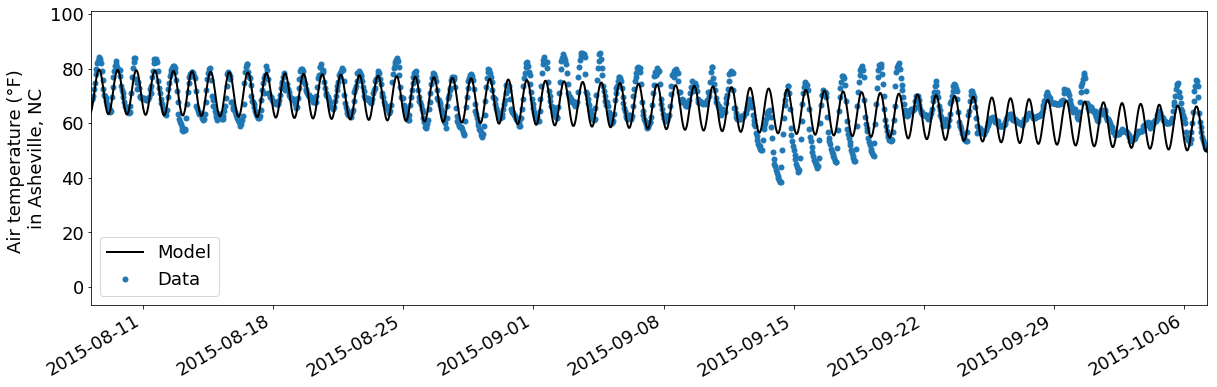

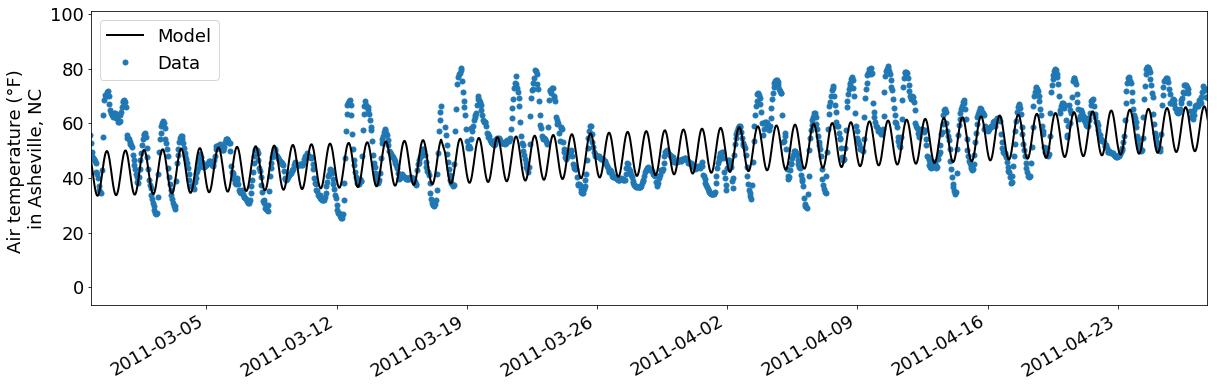

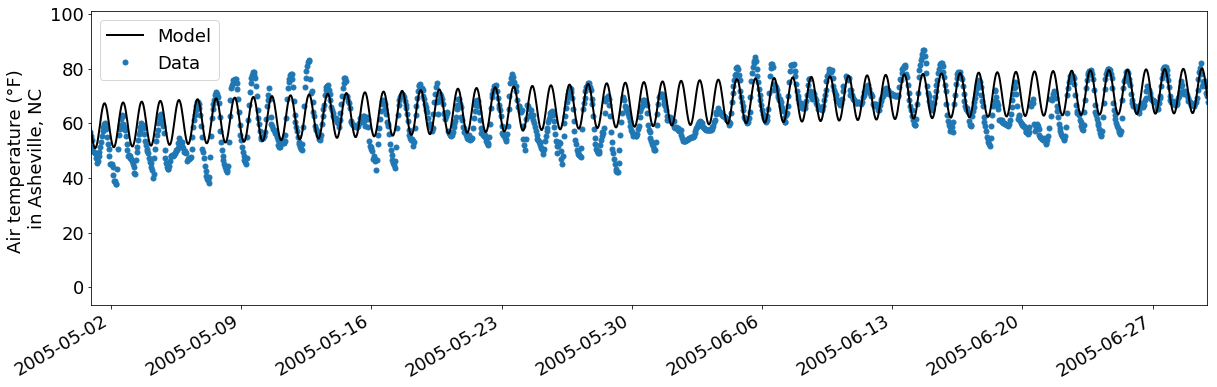

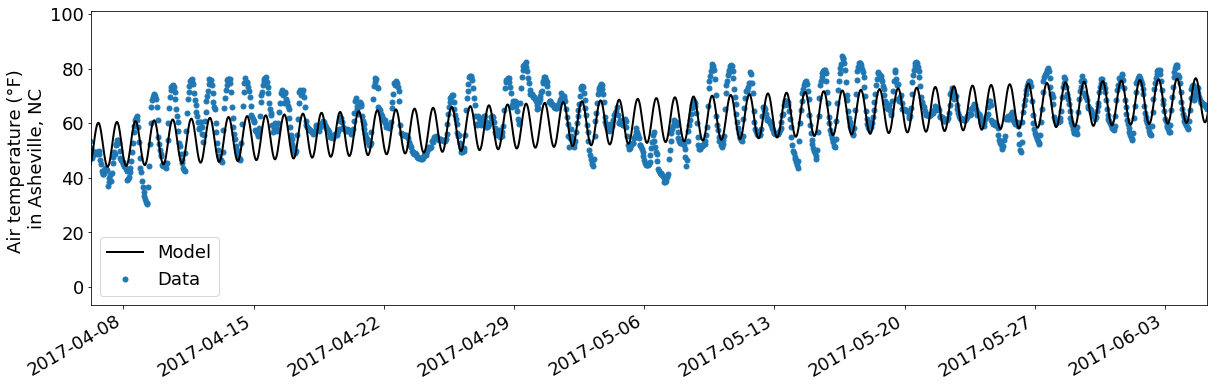

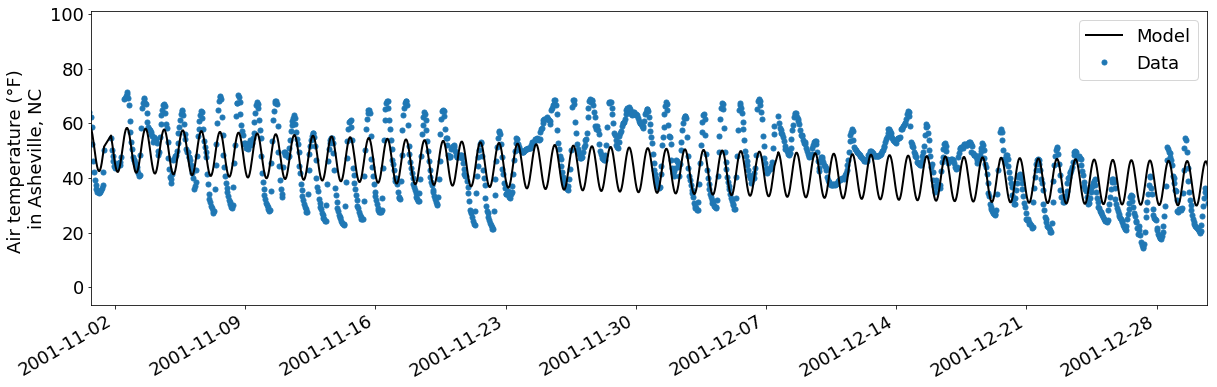

In [29]:
# To illustrate the autocorrelation in residuals,
# show data and model on some longer timescales
plt.rcParams['figure.figsize'] = 20,6
plt.rcParams['font.size'] = 18
window = 60
for startdt in pd.to_datetime(df.date[:-window*24].sample(5).values):
    plt.plot(
        dt, sine(x, *p) + sine_h(df.date.dt.hour, *p_h),
        lw = 2, c = 'black', zorder = 9001
    )
    df.set_index('date').Fahrenheit.plot(
        marker = 'o', markersize = 5, lw = 0, 
        alpha = 1, legend = False 
    )
    plt.xlim([startdt, startdt + timedelta(days = window)])
    plt.xlabel('')
    plt.ylabel('Air temperature (°F) \nin Asheville, NC')
    plt.legend(['Model', 'Data'])
    plt.show()

# Alternative approach: Fourier analysis

In [30]:
# Prepare for FFT by trimming the interpolated data 
# so that it spans an integer number of years
startdt = df_.date.iloc[0]
starters = (df_.date.dt.dayofyear == startdt.dayofyear) 
starters &= (df_.date.dt.hour == startdt.hour)
df_ = df_.iloc[:max(np.argwhere(starters))[0]]

In [31]:
# Get the FFT and prepare to pull its strongest terms
fft = np.fft.rfft(df_.Fahrenheit)
itop = np.abs(fft).argsort()[::-1]

FFT main components
-------------------
constant: 54.98°F
sinusoid: amplitude 17.79°F, period 365.250 days
sinusoid: amplitude 8.15°F, period 1.000 days
sinusoid: amplitude 1.81°F, period 0.500 days
sinusoid: amplitude 0.98°F, period 182.625 days
sinusoid: amplitude 0.97°F, period 1948.000 days


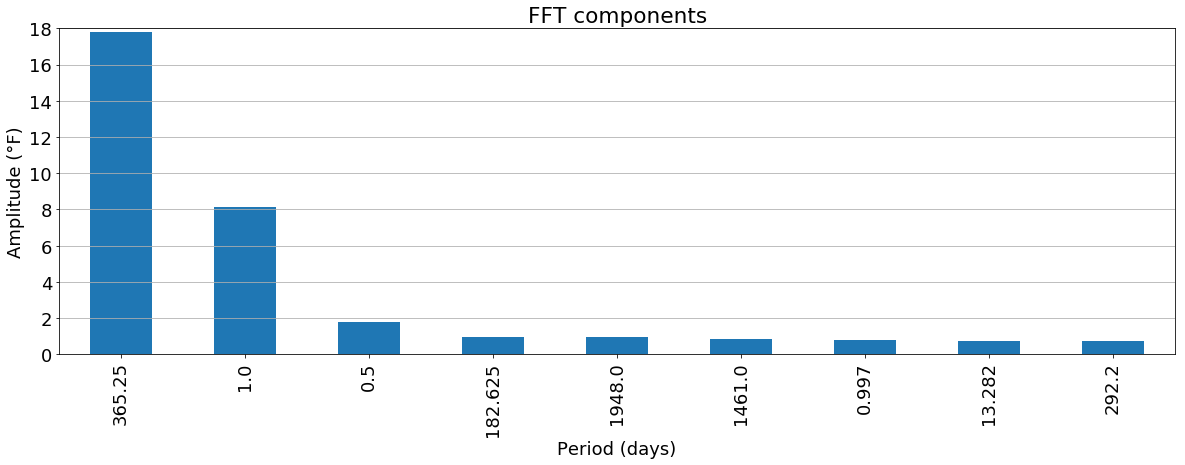

In [32]:
# Information about the FFT's leading terms
print('FFT main components')
print('-------------------')
for t in itop[:6]:
    if t == 0: print('constant: %.2f°F' % (np.abs(fft[t])/len(df_)))
    else: print(
        'sinusoid: amplitude %.2f°F, period %.3f days'
        % (np.abs(fft[t])/len(df_)*2, len(df_)/t/24)
    )

FFT = pd.DataFrame(
    list(enumerate(np.abs(fft)/len(df_)*2)),
    columns = ['Cycles', 'Amplitude']
).sort_values('Amplitude', ascending = False).iloc[1:10]
FFT['Period (days)'] = np.round(
    len(df_) / FFT.Cycles / 24, 
    decimals = 3
)
FFT.set_index('Period (days)')[['Amplitude']].plot(
    kind = 'bar', legend = False
)
plt.grid(axis = 'y')
plt.ylabel('Amplitude (°F)')
plt.ylim([0,18])
plt.title('FFT components')
plt.show()        

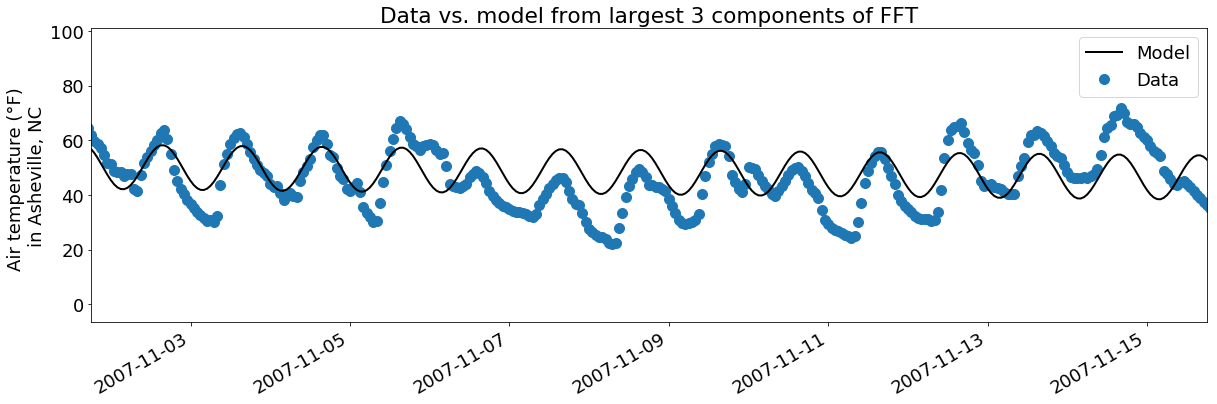

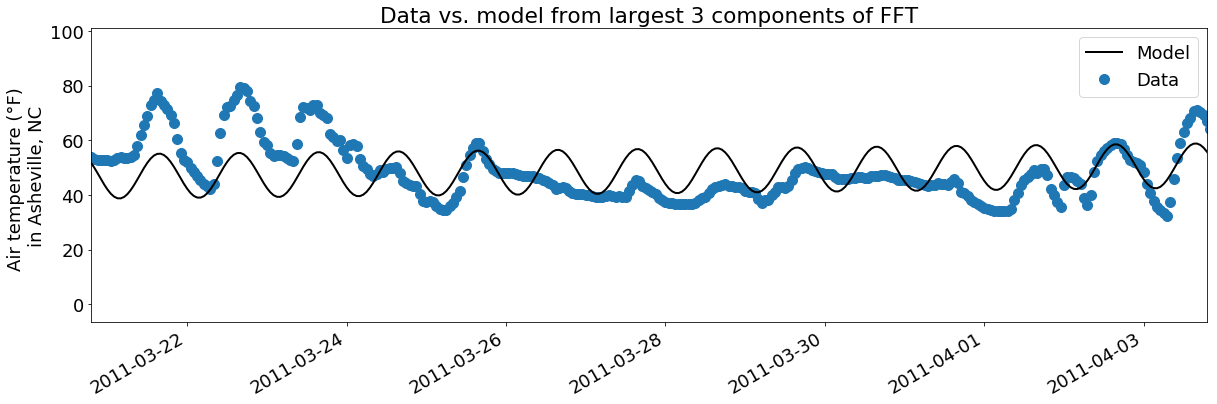

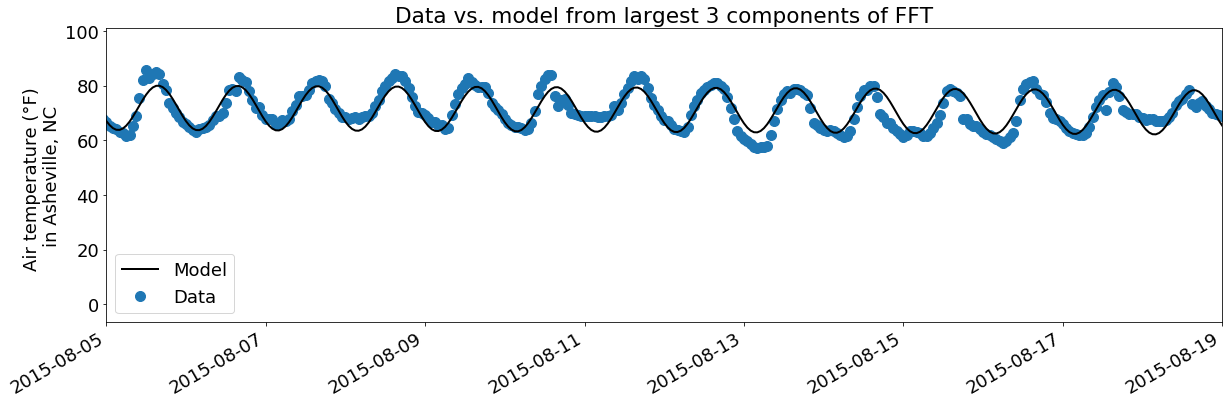

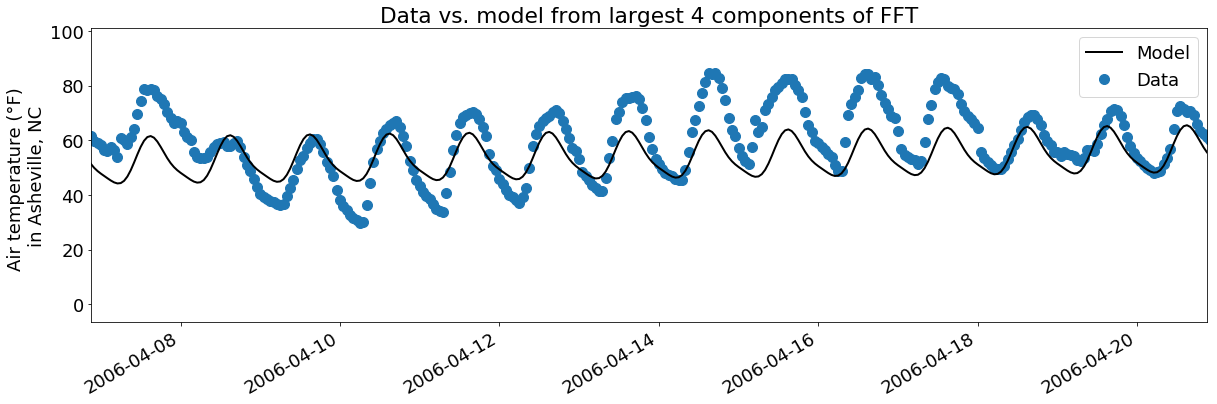

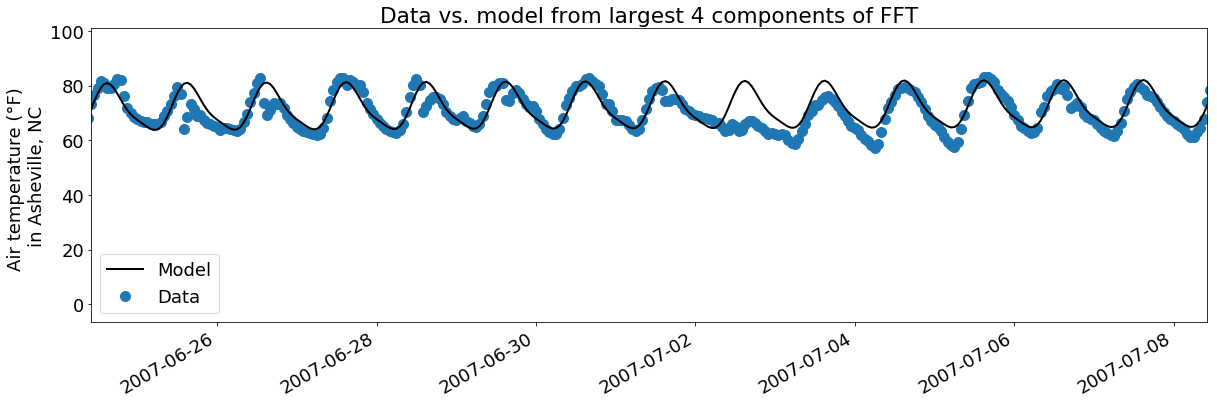

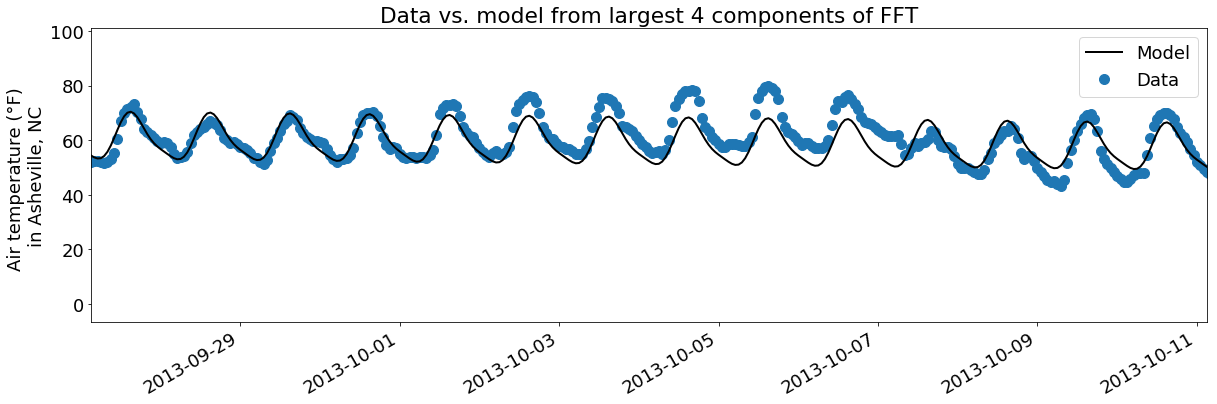

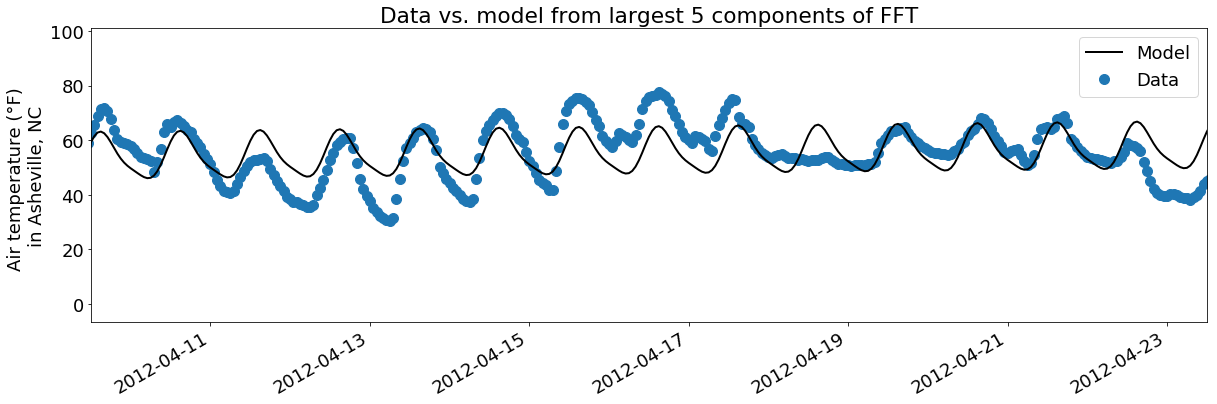

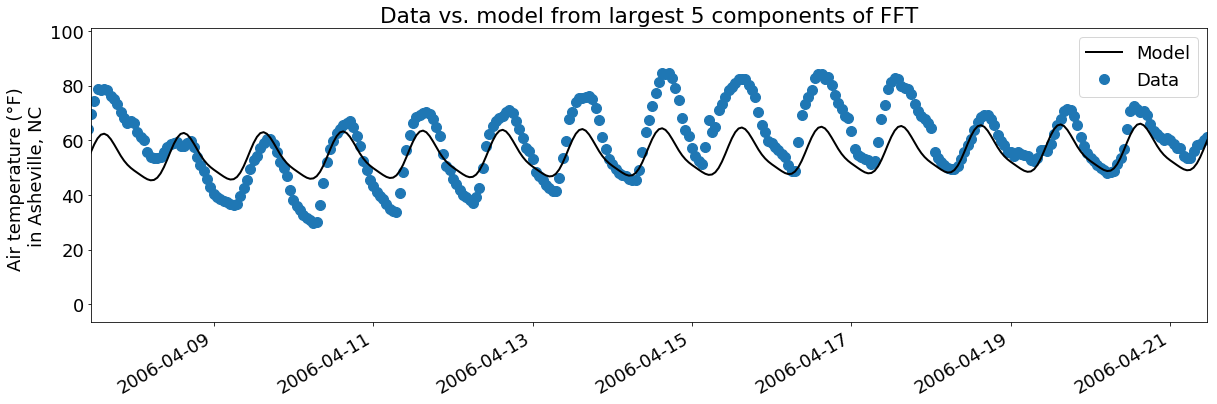

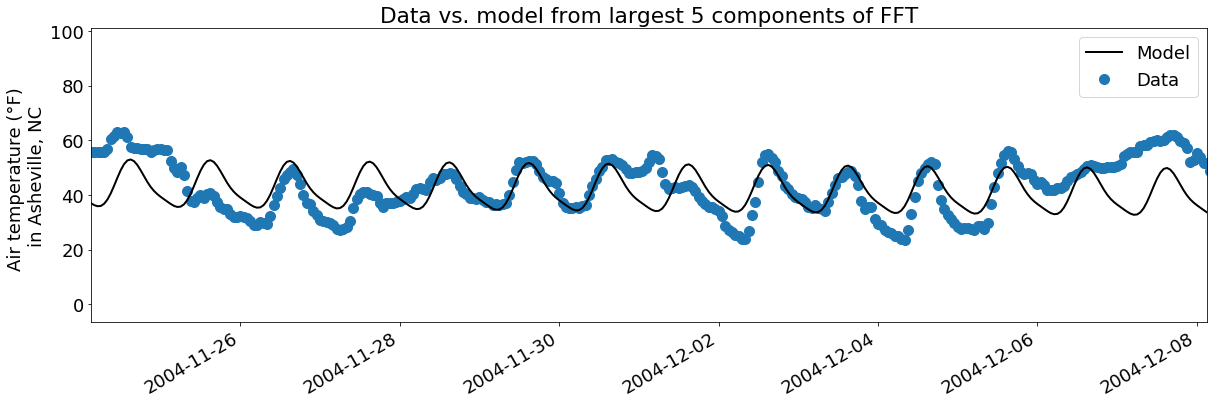

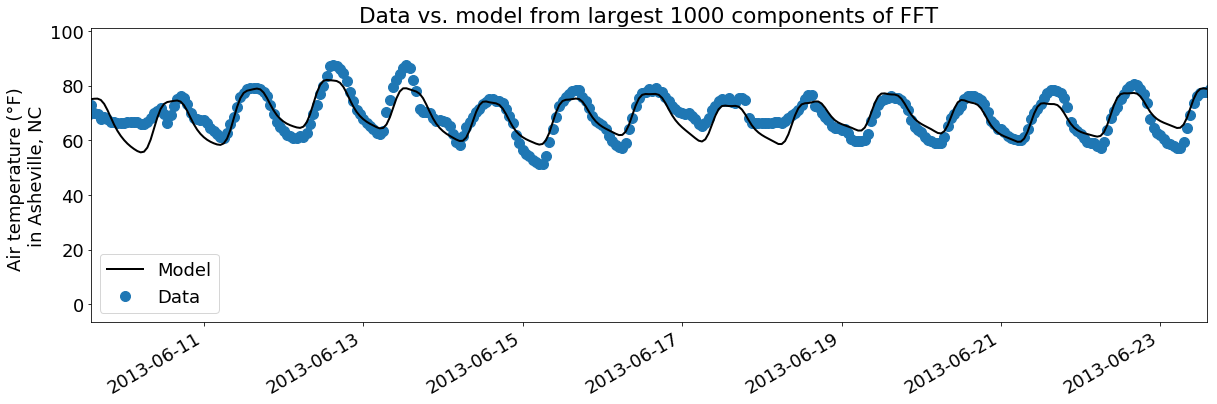

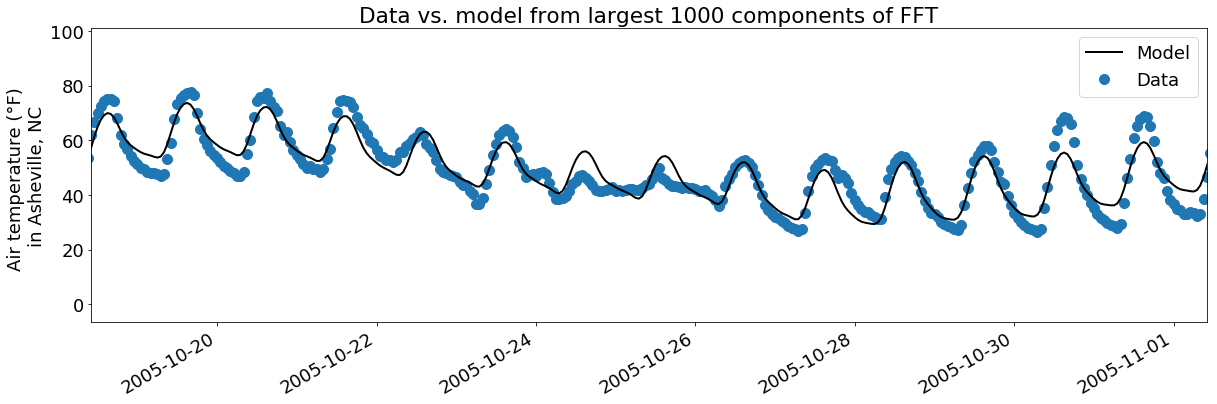

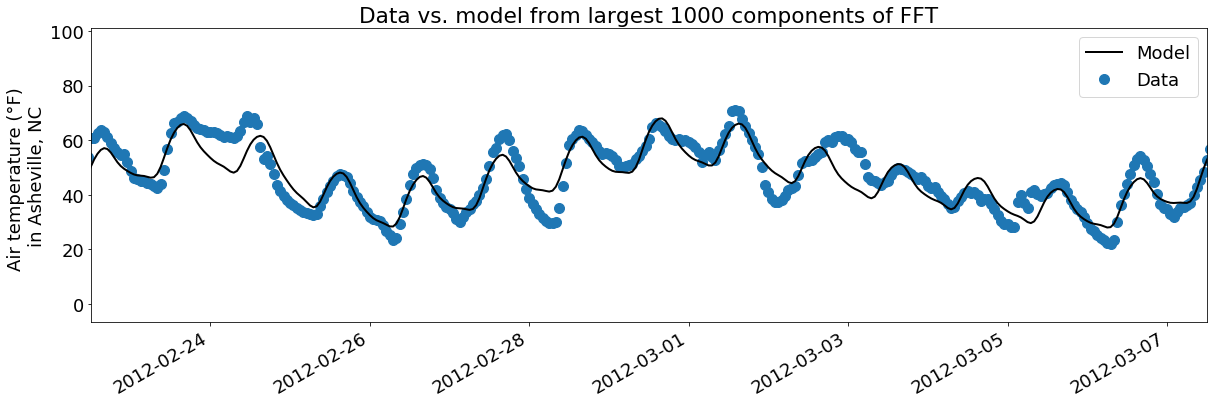

In [33]:
# Modeling with truncated FFT
window = 14    
x = [date2num(t) for t in df_.date]
dt = [num2date(t) for t in x]

# Number of components to use
for ncomp in [3, 4, 5, 1000]:
    # Truncated FFT
    fft_trunc = [
        f if i in itop[:ncomp] else 0 
        for i,f in enumerate(fft)
    ]
    
    # Resulting model
    ifft = np.fft.irfft(fft_trunc)

    # Compare to data on some randomly-selected short timescales
    for startdt in pd.to_datetime(df_.date[:-window*24].sample(3).values):
        plt.plot(
            dt, ifft,
            lw = 2, c = 'black', zorder = 9001
        )
        df_.set_index('date').Fahrenheit.plot(
            marker = 'o', alpha = 1, legend = False, 
            lw = 0, markersize = 10
        )
        plt.xlim([startdt, startdt + timedelta(days = window)])
        plt.xlabel('')
        plt.ylabel('Air temperature (°F) \nin Asheville, NC')
        plt.legend(['Model', 'Data'])
        plt.title('Data vs. model from largest %d components of FFT' % ncomp)
        plt.show()

In [34]:
# Calculate the residuals for 3-term FFT-based model
fft_trunc = [f if i in itop[:3] else 0  for i,f in enumerate(fft)]
resid = df_.set_index('date').Fahrenheit - np.fft.irfft(fft_trunc)
resid = resid.reset_index()

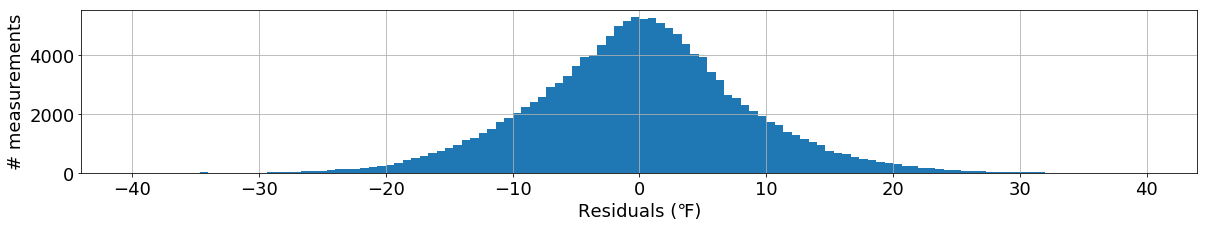

RMSE 8.286403612714945


In [35]:
# Distributions of the residuals
plt.rcParams['figure.figsize'] = 20,3
plt.rcParams['font.size'] = 18

resid.Fahrenheit.hist(bins = np.linspace(-40,40,121))
plt.xlabel('Residuals (℉)')
plt.ylabel('# measurements')
plt.show()

print('RMSE', (np.mean(resid.Fahrenheit**2))**.5)